# Iteration 16th

With the amout of different code it become easier to make each evolution separate to keep them clear in their weekly notebook

## $R^2$ calculation

In [1]:
#r2   = r2_score(y_test, y_pred)
#r2   = max(0.0, r2)

#print(f"{r2:.4f}")

## Bigger model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

from PyEMD import EMD
from scipy.signal import hilbert

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# 1) Load & scale
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)
X_raw = df[['volatility']].values    # shape (T,1)
y_raw = df[['volatility_forcast']].values  # shape (T,1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw).flatten()  # make it (T,) for easier indexing


In [4]:
# 2) Compute EMD‐based window sizes τₜ
max_W = 20
emd     = EMD()

imfs    = emd.emd(X_scaled.flatten())    # must pass a 1-D array
all_amp = [ np.abs(hilbert(imf)) for imf in imfs ]
all_pow = [ amp**2 for amp in all_amp ]
energies = [ p.mean() for p in all_pow ]

inst_power_norm = np.zeros_like(X_scaled.flatten(), dtype=float)
for p, E in zip(all_pow, energies):
    inst_power_norm += (p / E)

tau_emd = np.clip(np.round(inst_power_norm).astype(int), 1, max_W)
print("first 20 EMD windows:", tau_emd[:20])


first 20 EMD windows: [20 16 16 15 12 11 11 10 10  9  9  9 10 11 10  9 11 11  9  9]


In [5]:
# --- 3) Build dynamic sequences + mask, now also returning the original row‐indices ---
def create_dynamic_sequences_with_mask(X, y, tau, max_len):
    Xs, masks, ys, idxs = [], [], [], []
    T, D = X.shape
    for t in range(T):
        w = tau[t]
        if t < w:
            continue

        window = X[t-w : t]       # shape (w, D)
        m      = np.ones((w,1))
        if w < max_len:
            pad_X = np.zeros((max_len - w, D))
            pad_m = np.zeros((max_len - w, 1))
            window = np.vstack([pad_X, window])
            m      = np.vstack([pad_m,    m     ])

        Xs.append(window)         # → (max_len, D)
        masks.append(m)           # → (max_len, 1)
        ys.append(y[t])           # scalar target
        idxs.append(t)            # record that this sample “ends” at original row t
    return np.stack(Xs), np.stack(masks), np.array(ys), np.array(idxs)

X_dyn, M_dyn, y_dyn, idx_dyn = create_dynamic_sequences_with_mask(
    X_scaled,    # (T,1)
    y_scaled,    # (T,)
    tau_emd,     # (T,)
    max_W        # scalar
)

print("X_dyn:", X_dyn.shape, "M_dyn:", M_dyn.shape, "y_dyn:", y_dyn.shape)
# X_dyn = (N, max_W, D), M_dyn = (N, max_W, 1), y_dyn = (N,)


X_dyn: (5360, 20, 1) M_dyn: (5360, 20, 1) y_dyn: (5360,)


In [6]:
# 4) Concatenate mask as extra feature
X_with_mask = np.concatenate([X_dyn, M_dyn], axis=2)
# now shape = (N, max_W, D+1)

In [7]:
# --- 5) Train/test split, now also splitting idx_dyn to get test_idx ---

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_with_mask,    # features
    y_dyn,          # targets
    idx_dyn,        # row‐indices in df
    test_size=0.2,
    shuffle=False
)


In [8]:
# 6) Broadcast each scalar target into a seq‐length long vector
def build_y_seqs(y_flat, seq_length):
    N = len(y_flat)
    Y = np.zeros((N, seq_length, 1))
    for i, val in enumerate(y_flat):
        Y[i, :, 0] = val
    return Y

Y_train = build_y_seqs(y_train, max_W)
Y_test  = build_y_seqs(y_test,  max_W)

In [ ]:

class MaskedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        """
        Same API as before:
          - input_dim   = D (number of “real” features per time step)
          - hidden_dim1 = 256
          - hidden_dim2 = 128
          - output_dim  = 1

        Internally, we just stack two nn.LSTMCell modules, and before
        each time step we “hard‐forget” by multiplying h and c by mask_t.
        """
        super().__init__()
        self.input_dim  = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim

        # Layer‐1: input→256
        self.cell1 = nn.LSTMCell(input_dim, hidden_dim1)
        # Layer‐2: 256→128
        self.cell2 = nn.LSTMCell(hidden_dim1, hidden_dim2)
        # Final linear: 128→output_dim
        self.out   = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x_with_mask):
        """
        x_with_mask: (batch, seq_len, input_dim+1)
          – last channel is the 0/1 mask
          – first input_dim channels are the “real” features.
        Returns: y_preds of shape (batch, seq_len, output_dim)
        """
        batch, seq_len, Dp = x_with_mask.size()
        assert Dp == self.input_dim + 1

        data = x_with_mask[:, :, :-1]  # (batch, seq_len, input_dim)
        mask = x_with_mask[:, :, -1:]  # (batch, seq_len, 1)

        # initialize h1,c1 and h2,c2 to zero:
        h1 = data.new_zeros(batch, self.hidden_dim1)
        c1 = data.new_zeros(batch, self.hidden_dim1)
        h2 = data.new_zeros(batch, self.hidden_dim2)
        c2 = data.new_zeros(batch, self.hidden_dim2)

        outs = []
        for t in range(seq_len):
            x_t = data[:, t, :]     # (batch, input_dim)
            m_t = mask[:, t, :]     # (batch, 1); either 0.0 or 1.0

            # —— Layer 1 “hard‐forget” step:
            h1 = h1 * m_t
            c1 = c1 * m_t
            # then run the built-in LSTMCell once:
            h1, c1 = self.cell1(x_t, (h1, c1))

            # —— Layer 2 “hard‐forget” step:
            h2 = h2 * m_t
            c2 = c2 * m_t
            # feed the *output* of layer1 into layer2:
            h2, c2 = self.cell2(h1, (h2, c2))

            # finally compute y_t = Linear(h2)
            y_t = self.out(h2)            # (batch, output_dim)
            outs.append(y_t.unsqueeze(1)) # keep a time dimension

        # stack over time → (batch, seq_len, output_dim)
        return torch.cat(outs, dim=1)

In [10]:
# 8) Prepare data → move to torch.Tensor; define optimizer & loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy to torch, move to device
X_train_t = torch.from_numpy(X_train).float().to(device)  # (N_train, seq_len, D+1)
Y_train_t = torch.from_numpy(Y_train).float().to(device)  # (N_train, seq_len, 1)
X_test_t  = torch.from_numpy(X_test) .float().to(device)  # (N_test,  seq_len, D+1)
Y_test_t  = torch.from_numpy(Y_test) .float().to(device)  # (N_test,  seq_len, 1)

# Instantiate the bigger model:
#   – input_dim  = D  = X_train.shape[2] - 1
#   – hidden_dim1 = 256
#   – hidden_dim2 = 128
#   – output_dim = 1
model = MaskedLSTM(
    input_dim   = X_train.shape[2] - 1,
    hidden_dim1 = 256,
    hidden_dim2 = 128,
    output_dim  = 1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [11]:
# 9) Training loop
num_epochs = 100
batch_size = 32
N_train = X_train_t.size(0)

for epoch in range(1, num_epochs+1):
    perm = torch.randperm(N_train, device=device)
    X_perm = X_train_t[perm]
    Y_perm = Y_train_t[perm]

    running_loss = 0.0
    num_batches = math.ceil(N_train / batch_size)

    for i in range(0, N_train, batch_size):
        xb = X_perm[i : i+batch_size]   # (b, seq_len, D+1)
        yb = Y_perm[i : i+batch_size]   # (b, seq_len, 1)

        optimizer.zero_grad()
        preds = model(xb)               # (b, seq_len, 1)
        loss  = criterion(preds, yb)    # MSE over all time steps
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / num_batches

    # Validation loss:
    with torch.no_grad():
        val_preds = model(X_test_t)                     # (N_test, seq_len, 1)
        val_loss = criterion(val_preds, Y_test_t).item()

    print(f"Epoch {epoch}/{num_epochs} — train MSE: {avg_train_loss:.6f} — val MSE: {val_loss:.6f}")



Epoch 1/100 — train MSE: 0.007646 — val MSE: 0.004633
Epoch 2/100 — train MSE: 0.005376 — val MSE: 0.005312
Epoch 3/100 — train MSE: 0.005288 — val MSE: 0.005086
Epoch 4/100 — train MSE: 0.005360 — val MSE: 0.004724
Epoch 5/100 — train MSE: 0.005186 — val MSE: 0.004637
Epoch 6/100 — train MSE: 0.005266 — val MSE: 0.004770
Epoch 7/100 — train MSE: 0.005303 — val MSE: 0.004480
Epoch 8/100 — train MSE: 0.005177 — val MSE: 0.004674
Epoch 9/100 — train MSE: 0.005210 — val MSE: 0.004536
Epoch 10/100 — train MSE: 0.005153 — val MSE: 0.004514
Epoch 11/100 — train MSE: 0.005113 — val MSE: 0.004686
Epoch 12/100 — train MSE: 0.005182 — val MSE: 0.004779
Epoch 13/100 — train MSE: 0.005206 — val MSE: 0.004697
Epoch 14/100 — train MSE: 0.005212 — val MSE: 0.004553
Epoch 15/100 — train MSE: 0.005184 — val MSE: 0.004608
Epoch 16/100 — train MSE: 0.005098 — val MSE: 0.004544
Epoch 17/100 — train MSE: 0.005190 — val MSE: 0.004735
Epoch 18/100 — train MSE: 0.005141 — val MSE: 0.004721
Epoch 19/100 — trai

In [12]:
# 10) Predict & evaluate
with torch.no_grad():
    preds_seq_t = model(X_test_t)       # (N_test, seq_len, 1)
    preds_last_t = preds_seq_t[:, -1, 0]  # (N_test,)
    y_last_t     = Y_test_t[:, -1, 0]     # (N_test,)

preds_last = preds_last_t.cpu().numpy().reshape(-1,1)
y_last     = y_last_t    .cpu().numpy().reshape(-1,1)

preds_inv = scaler_y.inverse_transform(preds_last).flatten()
y_inv     = scaler_y.inverse_transform(y_last)    .flatten()

mse  = mean_squared_error(y_inv, preds_inv)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_inv, preds_inv)
mape = mean_absolute_percentage_error(y_inv, preds_inv)
r2   = r2_score(y_inv, preds_inv)

print(f"\nTest MSE={mse:.6f}  RMSE={rmse:.6f}  MAE={mae:.6f}")
print(f"     MAPE={100*mape:.2f}%  R²={r2:.4f}")



Test MSE=0.003363  RMSE=0.057988  MAE=0.040741
     MAPE=65.65%  R²=0.3907


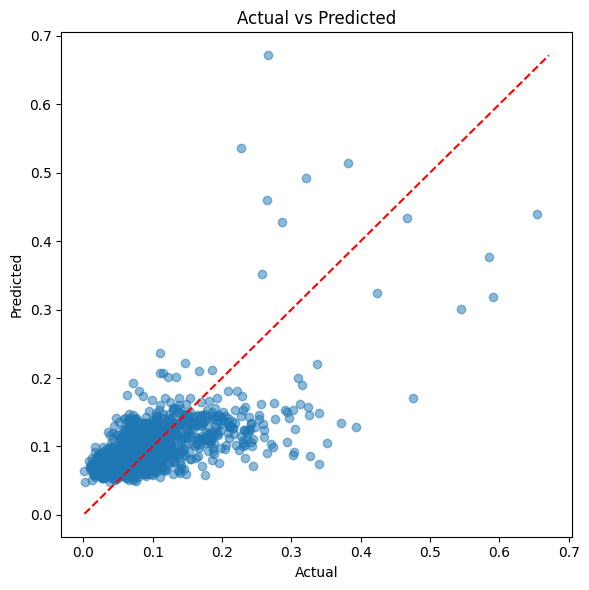

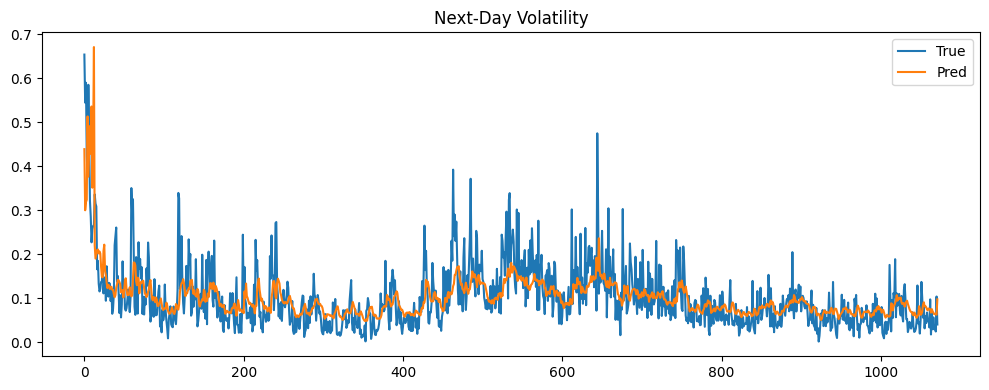

In [13]:
# 11) Quick plots (unchanged)
plt.figure(figsize=(6,6))
plt.scatter(y_inv, preds_inv, alpha=0.5)
lims = [
    min(y_inv.min(), preds_inv.min()),
    max(y_inv.max(), preds_inv.max())
]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(y_inv,    label='True')
plt.plot(preds_inv, label='Pred')
plt.legend()
plt.title("Next-Day Volatility")
plt.tight_layout()
plt.show()


Saving (optionnal)

In [14]:
# 11) Write back into df
df['vol_LSTM'] = np.nan
df.loc[idx_test, 'vol_LSTM'] = preds_inv

# 12) Optionally save out
df.to_csv('../../data/dataV.csv', index=False)

## Probabilistic model

### Price

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [16]:
# 1) Load and preprocess data
# ----------------------------
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

# 2) Create Movement column
#    Movement[t] = 1 if Close[t+1] > Close[t], else 0
df['Movement'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# 3) Create Target column
#    Target[t] = Movement[t+1], i.e. did price go up from t+1 to t+2?
df['Target']   = df['Movement'].shift(-1)

# 4) Drop the last two rows (they have NaNs in Movement/Target)
df.dropna(subset=['Movement', 'Target'], inplace=True)

# 5) Extract arrays for modeling
prices = df['Movement'].values
labels = df['Target'].astype(int).values

# 6) Z-score normalization of prices
prices = (prices - prices.mean()) / prices.std()


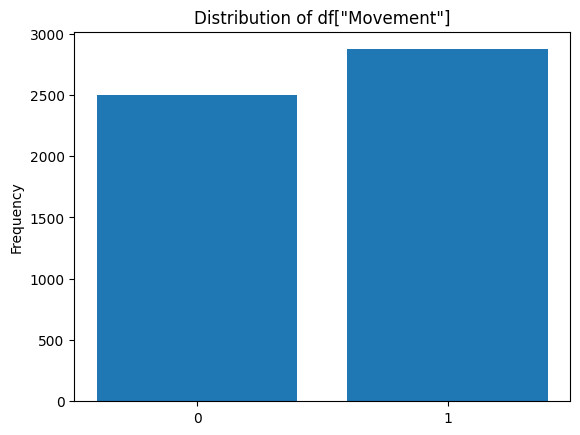

In [17]:
import matplotlib.pyplot as plt

# Count how many 0’s and 1’s
counts = df['Movement'].value_counts().sort_index()

# Create bar‐plot
plt.bar(counts.index, counts.values)
plt.xlabel('')
plt.ylabel('Frequency')
plt.title('Distribution of df["Movement"]')
plt.xticks([0, 1])
plt.show()


In [18]:
# (d) Build sliding windows of length=5
seq_len = 5
sequences = []
seq_labels = []

for i in range(len(prices) - seq_len):
    sequences.append(prices[i : i + seq_len])
    seq_labels.append(labels[i + seq_len])

sequences = np.array(sequences)      # shape: (N, seq_len)
seq_labels = np.array(seq_labels)    # shape: (N,)

In [19]:

# (e) Train/test split (80% train, 20% test)
split_idx = int(0.8 * len(sequences))
X_train_np, X_test_np = sequences[:split_idx], sequences[split_idx:]
y_train_np, y_test_np = seq_labels[:split_idx], seq_labels[split_idx:]

# (f) Convert to PyTorch tensors and add the feature-dimension
#     Final shapes: [batch, seq_len, 1]
X_train = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(-1)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train_np, dtype=torch.long)
y_test  = torch.tensor(y_test_np, dtype=torch.long)

# (g) Use TensorDataset instead of a custom Dataset class
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)


In [20]:
# 2) Define a two-layer LSTM classifier: hidden sizes 64 → 32
# -----------------------------------------------------------
class LSTMClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        # x: [batch, seq_len, 1]
        out, _ = self.lstm1(x)       # out: [batch, seq_len, 64]
        out, _ = self.lstm2(out)     # out: [batch, seq_len, 32]
        last = out[:, -1, :]         # take last time step → [batch, 32]
        return self.fc(last)         # [batch, 2]

model     = LSTMClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [21]:
# 3) Training loop
# ----------------------------
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)                   # [batch, 2]
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}  –  Loss: {avg_loss:.4f}")


Epoch 1/100  –  Loss: 0.6923
Epoch 2/100  –  Loss: 0.6913
Epoch 3/100  –  Loss: 0.6912
Epoch 4/100  –  Loss: 0.6911
Epoch 5/100  –  Loss: 0.6910
Epoch 6/100  –  Loss: 0.6910
Epoch 7/100  –  Loss: 0.6910
Epoch 8/100  –  Loss: 0.6909
Epoch 9/100  –  Loss: 0.6909
Epoch 10/100  –  Loss: 0.6909
Epoch 11/100  –  Loss: 0.6909
Epoch 12/100  –  Loss: 0.6908
Epoch 13/100  –  Loss: 0.6908
Epoch 14/100  –  Loss: 0.6908
Epoch 15/100  –  Loss: 0.6907
Epoch 16/100  –  Loss: 0.6907
Epoch 17/100  –  Loss: 0.6906
Epoch 18/100  –  Loss: 0.6905
Epoch 19/100  –  Loss: 0.6905
Epoch 20/100  –  Loss: 0.6904
Epoch 21/100  –  Loss: 0.6904
Epoch 22/100  –  Loss: 0.6903
Epoch 23/100  –  Loss: 0.6903


KeyboardInterrupt: 

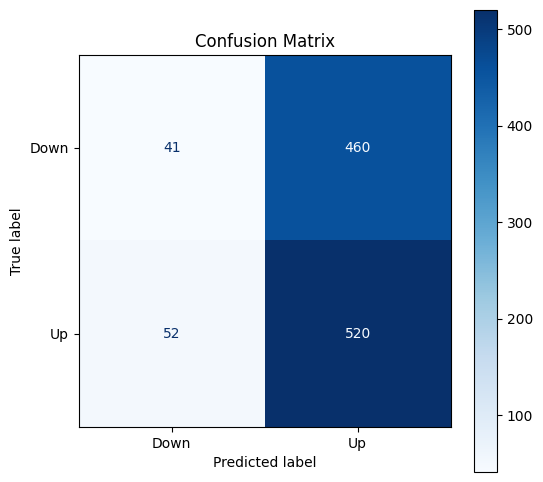

In [ ]:
# 4) Evaluate on test set and plot confusion matrix
# --------------------------------------------------
model.eval()
all_preds = []
all_targs = []

with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)                      # [batch, 2]
        preds = torch.argmax(logits, dim=1)     # [batch]
        all_preds.extend(preds.cpu().numpy().tolist())
        all_targs.extend(yb.cpu().numpy().tolist())

cm = confusion_matrix(all_targs, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### Density function of sigma

mean = sum(sum(SDi/n))


In [55]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [56]:
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)


In [57]:
# 2) Compute features + targets
df['returns_sd']          = df['volatility'].expanding().std(ddof=10)
df['returns_sd_mean']     = df['returns_sd'].expanding().mean()
df['returns_sd_target']      = df['returns_sd'].shift(-1)
df['returns_sd_mean_target'] = df['returns_sd_mean'].shift(-1)

# 3) Drop *every* row that has any NaN in our columns of interest
cols = ['returns','returns_sd','returns_sd_mean',
        'returns_sd_target','returns_sd_mean_target']
df = df.dropna(subset=cols).reset_index(drop=True)

# 4) Verify no NaNs remain
assert not df[cols].isna().any().any(), "There are still NaNs!"


In [58]:
df['returns'].expanding()

Expanding [min_periods=1,axis=0,method=single]

In [59]:
df['returns']      


0       0.5620
1       0.5596
2       0.5684
3       0.6013
4       0.5384
         ...  
5353    0.5697
5354    0.5549
5355    0.6237
5356    0.6006
5357    0.5941
Name: returns, Length: 5358, dtype: float64

In [60]:
df['returns_sd']      


0       0.126977
1       0.094339
2       0.077953
3       0.067600
4       0.086100
          ...   
5353    0.086731
5354    0.086725
5355    0.086721
5356    0.086717
5357    0.086714
Name: returns_sd, Length: 5358, dtype: float64

In [ ]:
# 8) Plot distributions of the three features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# returns_sd
axes[0].hist(df['returns_sd'], bins=50, alpha=0.7)
axes[0].set_title('Distribution of returns_sd')
axes[0].set_xlabel('returns_sd')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# returns_sd_mean
axes[1].hist(df['returns_sd_mean'], bins=50, alpha=0.7)
axes[1].set_title('Distribution of returns_sd_mean')
axes[1].set_xlabel('returns_sd_mean')
axes[1].grid(True)

# returns
axes[2].hist(df['volatility'], bins=50, alpha=0.7)
axes[2].set_title('Distribution of returns')
axes[2].set_xlabel('returns')
axes[2].grid(True)

plt.tight_layout()
plt.show()

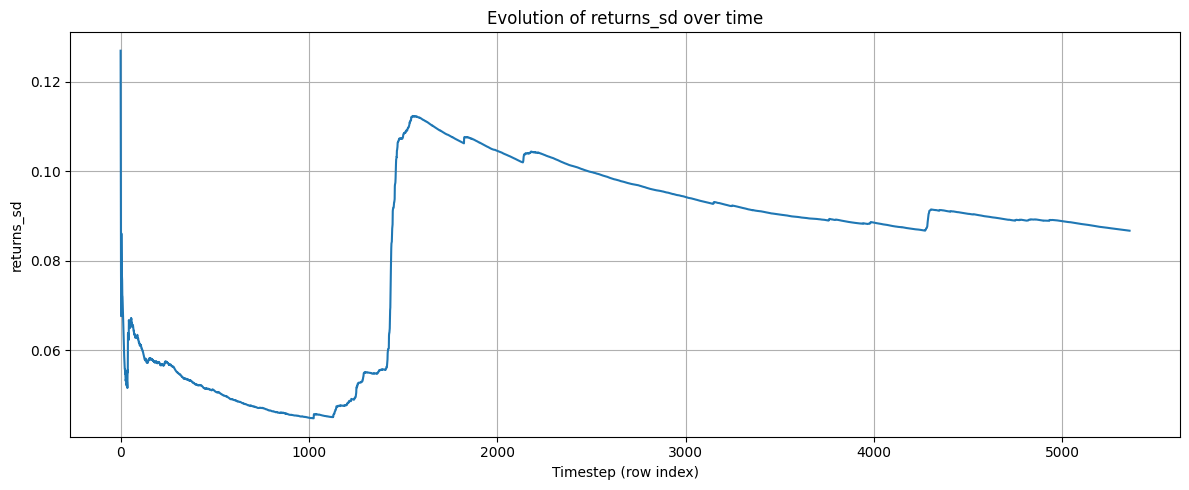

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['returns_sd'])
plt.title('Evolution of returns_sd over time')
plt.xlabel('Timestep (row index)')
plt.ylabel('returns_sd')
plt.grid(True)
plt.tight_layout()
plt.show()


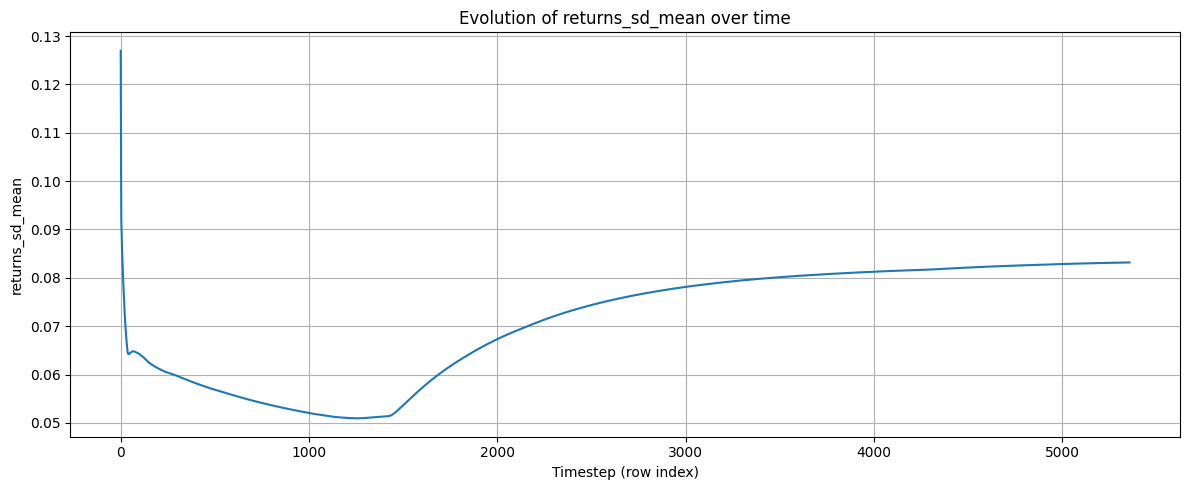

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['returns_sd_mean'])
plt.title('Evolution of returns_sd_mean over time')
plt.xlabel('Timestep (row index)')
plt.ylabel('returns_sd_mean')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 2) Dataset & DataLoader
class SequenceDataset(Dataset):
    def __init__(self, df, seq_len=10):
        self.X = df[['returns_sd','returns','returns_sd_mean']].values.astype(np.float32)
        self.y = df[['returns_sd_target','returns_sd_mean_target']].values.astype(np.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx + self.seq_len]
        y_target = self.y[idx + self.seq_len]
        return (
            torch.from_numpy(x_seq),
            torch.from_numpy(y_target),
        )

seq_len   = 10
batch_sz  = 32
dataset   = SequenceDataset(df, seq_len=seq_len)
loader    = DataLoader(dataset, batch_size=batch_sz, shuffle=True)


In [ ]:

# 3) Model
class LSTMForecast(nn.Module):
    def __init__(self, input_size=3, hidden1=64, hidden2=32, output_size=2):
        super().__init__()
        # first LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden1, batch_first=True)
        # second LSTM layer
        self.lstm2 = nn.LSTM(hidden1, hidden2, batch_first=True)
        # final linear to 2 targets
        self.lin   = nn.Linear(hidden2, output_size)

    def forward(self, x):
        # x: [batch, seq_len, input_size]
        out, _ = self.lstm1(x)       # → [batch, seq_len, hidden1]
        out, _ = self.lstm2(out)     # → [batch, seq_len, hidden2]
        out = out[:, -1, :]          # take last timestep → [batch, hidden2]
        return self.lin(out)         # → [batch, output_size]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = LSTMForecast().to(device)
opt    = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn= nn.MSELoss()

In [ ]:
# 4) Training loop
epochs = 20
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        loss  = loss_fn(preds, y_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * x_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    print(f"Epoch {epoch:02d} — train MSE: {avg_loss:.6f}")

Epoch 01 — train MSE: 0.001030
Epoch 02 — train MSE: 0.000235
Epoch 03 — train MSE: 0.000066
Epoch 04 — train MSE: 0.000036
Epoch 05 — train MSE: 0.000034


KeyboardInterrupt: 

In [ ]:

# --- 6) Inference over your whole dataset for plotting ---
model.eval()
all_preds, all_actuals = [], []

# create a fresh loader with shuffle=False so order matches
infer_loader = DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for x_batch, y_batch in infer_loader:
        x_batch = x_batch.to(device)
        preds = model(x_batch).cpu().numpy()        # shape (batch, 2)
        all_preds.append(preds)
        all_actuals.append(y_batch.numpy())         # shape (batch, 2)

# stack into (N,2) arrays
all_preds   = np.vstack(all_preds)
all_actuals = np.vstack(all_actuals)


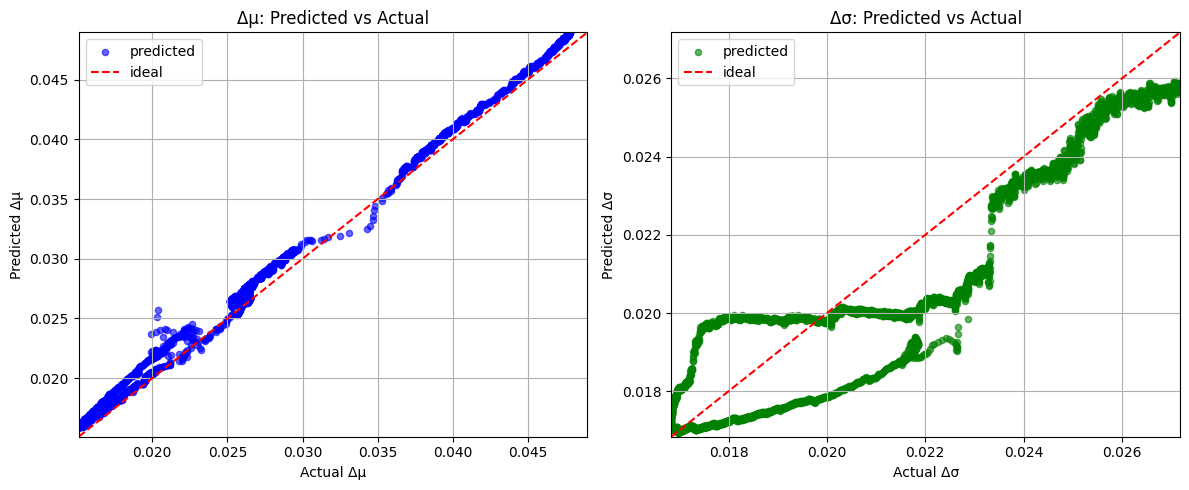

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- 7) Plot predicted vs actual side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: returns_sd_target (Δσ)
x0 = all_actuals[:, 0]   # true returns_sd_target
y0 = all_preds[:,     0] # pred returns_sd_target
lims0 = (min(x0.min(), y0.min()), max(x0.max(), y0.max()))

axes[0].scatter(x0, y0, s=20, alpha=0.6, color='blue', label='predicted')
axes[0].plot(lims0, lims0, '--', color='red', label='ideal')
axes[0].set_title(r'Δμ: Predicted vs Actual')
axes[0].set_xlabel(r'Actual Δμ')
axes[0].set_ylabel(r'Predicted Δμ')
axes[0].set_xlim(lims0)
axes[0].set_ylim(lims0)
axes[0].legend()
axes[0].grid(True)

# Right: returns_sd_mean_target (Δμ)
x1 = all_actuals[:, 1]   # true returns_sd_mean_target
y1 = all_preds[:,     1] # pred returns_sd_mean_target
lims1 = (min(x1.min(), y1.min()), max(x1.max(), y1.max()))

axes[1].scatter(x1, y1, s=20, alpha=0.6, color='green', label='predicted')
axes[1].plot(lims1, lims1, '--', color='red', label='ideal')
axes[1].set_title(r'Δσ: Predicted vs Actual')
axes[1].set_xlabel(r'Actual Δσ')
axes[1].set_ylabel(r'Predicted Δσ')
axes[1].set_xlim(lims1)
axes[1].set_ylim(lims1)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Confidence interval

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# load your data
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
prices = df['returns'].dropna().values

# 1) basic stats
n    = len(prices)
mean = prices.mean()
std  = prices.std(ddof=1)
se   = std / np.sqrt(n)

# 2) get t-critical for 95% two-tailed
alpha = 0.05
tcrit = stats.norm.ppf(1 - alpha/2)

# 3) confidence interval
lower = mean - tcrit*se
upper = mean + tcrit*se

print(f"n         = {n}")
print(f"mean      = {mean:.4f}")
print(f"std       = {std:.4f}")
print(f"95% CI    = [{lower:.4f}, {upper:.4f}]")


n         = 5369
mean      = 0.5866
std       = 0.0477
95% CI    = [0.5854, 0.5879]


In [ ]:
tcrit*se

0.001276973224413759

## Adding more features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# 1) Load & sort
# ---------------------------
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

# ---------------------------
# 2) Encode Date as a numeric feature
# ---------------------------
# Use Date.toordinal() so each date becomes an integer
df['Date_ordinal'] = df['Date'].apply(lambda dt: dt.toordinal())

# ---------------------------
# 3) Define feature columns & target
# ---------------------------
feature_cols = [
    'Date_ordinal',
    'Inflation',
    'CPI',
    'Treasury_Yield',
    #'Open',
    #'High',
    #'Low',
    'Close',
    'SP500_Adj_Close',
    'Volume',
    'GDP',
    'mortage',
    'unemployement',
    'fed_fund_rate',
    'volatility',
    # 'volatility_forcast',
    'returns',
    'EWMA_VM',
    'GARCH_VM',
    'EGARCH_VM',
    'RogersSatchell_VM',
    'garman_klass',
    'parkinson',
    'yang_zhang',
    #'BS_30d_ATM_Call',
    'move'
]

target_col = 'volatility_forcast'  # the one column we want to predict

# Make sure these columns exist in your CSV. If any are misspelled, adjust accordingly.
X_raw = df[feature_cols].values           # shape = (T, 25)
y_raw = df[[target_col]].values           # shape = (T, 1)

# ---------------------------
# 4) Standard‐scale X and y
# ---------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)  # (T, 25)
y_scaled = scaler_y.fit_transform(y_raw)  # (T, 1)

# ---------------------------
# 5) Create sliding‐window sequences
# ---------------------------
def create_sequences(X: np.ndarray, y: np.ndarray, seq_len: int):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t-seq_len:t, :])  # (seq_len, num_features)
        ys.append(y[t, :])            # (1,)
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)
# Now X_seq.shape = (num_samples, 20, 25),  y_seq.shape = (num_samples, 1)

# ---------------------------
# 6) Train/test split (no shuffle)
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.20, shuffle=False
)

# ---------------------------
# 7) DataLoader
# ---------------------------
batch_size = 256

train_dataset = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float()
)
test_dataset = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float()
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# ---------------------------
# 8) Two‐layer LSTM model
# ---------------------------
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=22, hidden_dim1=128, hidden_dim2=64):
        super().__init__()
        # First LSTM layer takes in `input_dim` features and outputs hidden_dim1 features
        self.lstm1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim1,
            num_layers=1,
            batch_first=True
        )
        # Second LSTM layer takes in hidden_dim1 features and outputs hidden_dim2
        self.lstm2 = nn.LSTM(
            input_size=hidden_dim1,
            hidden_size=hidden_dim2,
            num_layers=1,
            batch_first=True
        )
        # Final linear layer maps from hidden_dim2 → 1 (the forecast)
        self.fc = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        # x.shape = (batch_size, seq_len, input_dim)
        out1, _ = self.lstm1(x)       # out1.shape = (batch_size, seq_len, hidden_dim1)
        out2, _ = self.lstm2(out1)    # out2.shape = (batch_size, seq_len, hidden_dim2)
        last = out2[:, -1, :]         # take the last timestep → (batch_size, hidden_dim2)
        return self.fc(last)          # (batch_size, 1)

# Instantiate
model = LSTMForecast(input_dim=len(feature_cols), hidden_dim1=128, hidden_dim2=64)

# (Optional) set dropout on the LSTM layers if you want:
# model.lstm1.dropout = 0.2
# model.lstm2.dropout = 0.2

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# ---------------------------
# 9) Training loop
# ---------------------------
n_epochs = 200

for epoch in range(1, n_epochs + 1):
    model.train()
    total_loss = 0.0

    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)              # pred.shape = (batch_size, 1)
        loss = criterion(pred, yb)    # MSELoss
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs} — train MSE: {avg_train_loss:.6f}")

# ---------------------------
# 10) Evaluation on test set
# ---------------------------
model.eval()
preds_scaled, trues_scaled = [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        p = model(Xb)                 # (batch_size, 1)
        preds_scaled.append(p.cpu().numpy())
        trues_scaled.append(yb.cpu().numpy())

y_pred_scaled = np.vstack(preds_scaled)   # (num_test_samples, 1)
y_test_scaled = np.vstack(trues_scaled)   # (num_test_samples, 1)

# Inverse‐scale back to original volatility units
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Compute metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
r2   = max(0.0, r2)  # force non‐negative

print(f"\nTest MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


Epoch 1/100 — train MSE: 0.501797
Epoch 2/100 — train MSE: 0.419842
Epoch 3/100 — train MSE: 0.409566
Epoch 4/100 — train MSE: 0.398750
Epoch 5/100 — train MSE: 0.387107
Epoch 6/100 — train MSE: 0.388857
Epoch 7/100 — train MSE: 0.381871
Epoch 8/100 — train MSE: 0.373922
Epoch 9/100 — train MSE: 0.369314
Epoch 10/100 — train MSE: 0.360724
Epoch 11/100 — train MSE: 0.356220
Epoch 12/100 — train MSE: 0.364189
Epoch 13/100 — train MSE: 0.345504
Epoch 14/100 — train MSE: 0.336148
Epoch 15/100 — train MSE: 0.327450
Epoch 16/100 — train MSE: 0.314981
Epoch 17/100 — train MSE: 0.302291
Epoch 18/100 — train MSE: 0.286443
Epoch 19/100 — train MSE: 0.285446
Epoch 20/100 — train MSE: 0.277600
Epoch 21/100 — train MSE: 0.260283
Epoch 22/100 — train MSE: 0.247808
Epoch 23/100 — train MSE: 0.247456
Epoch 24/100 — train MSE: 0.237141
Epoch 25/100 — train MSE: 0.226197
Epoch 26/100 — train MSE: 0.210013
Epoch 27/100 — train MSE: 0.209591
Epoch 28/100 — train MSE: 0.199849
Epoch 29/100 — train MSE: 0.1

KeyboardInterrupt: 

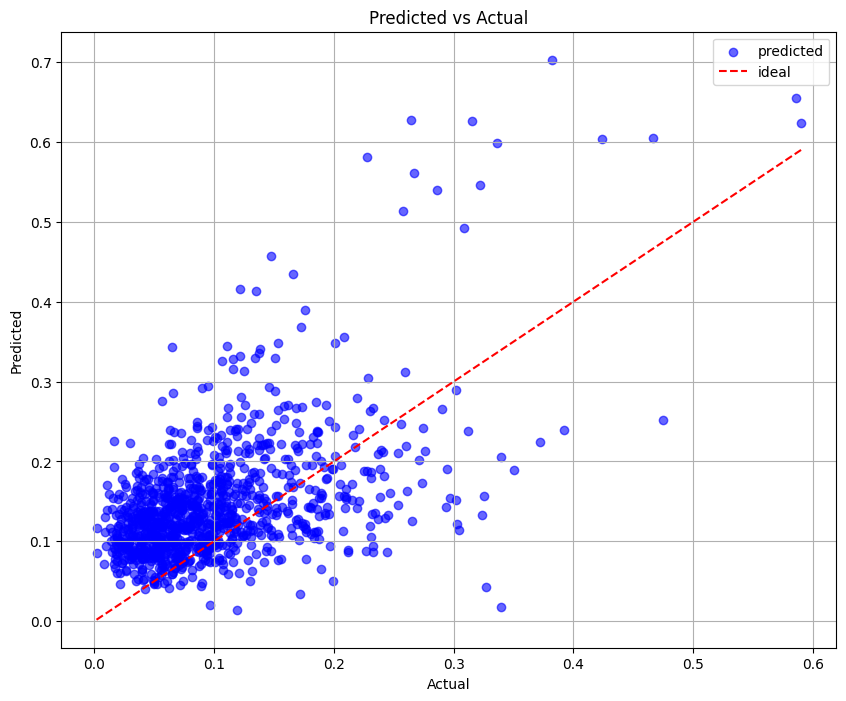

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label="predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="ideal")
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()


## Option price model with enhance volatility model + benchmark

### Base Black-Scholes

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

X_raw = df[['volatility', 'Close', 'Volume', 'returns', 'EWMA_VM', 'yang_zhang']].values    # (T, 1)
y_raw = df[['BS_30d_ATM_Call']].values  # (T, 1)

y_raw   # With normalization

array([[0.0288],
       [0.1102],
       [0.0434],
       ...,
       [0.1614],
       [0.117 ],
       [0.3856]])

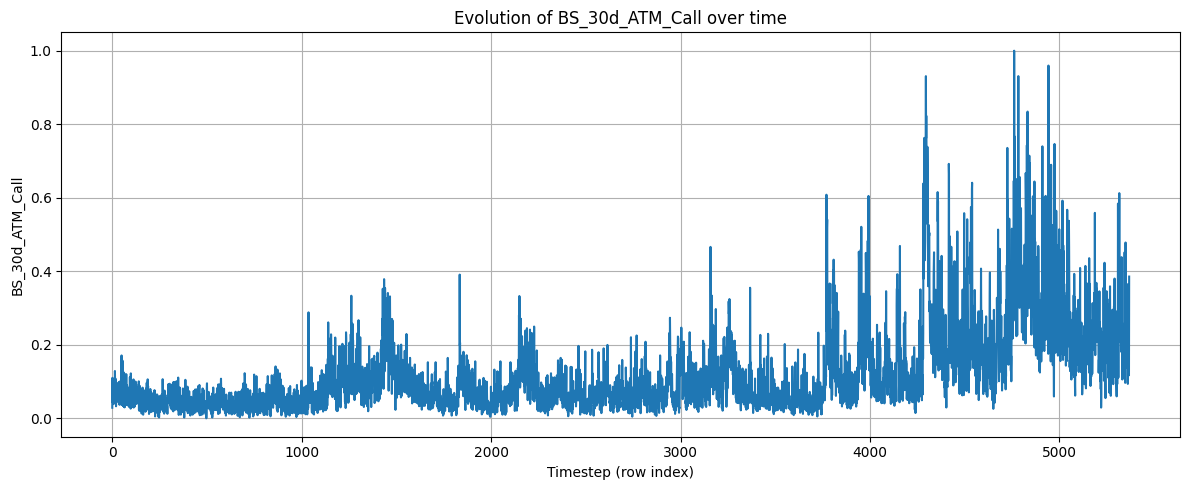

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['BS_30d_ATM_Call'])
plt.title('Evolution of BS_30d_ATM_Call over time')
plt.xlabel('Timestep (row index)')
plt.ylabel('BS_30d_ATM_Call')
plt.grid(True)
plt.tight_layout()
plt.show()


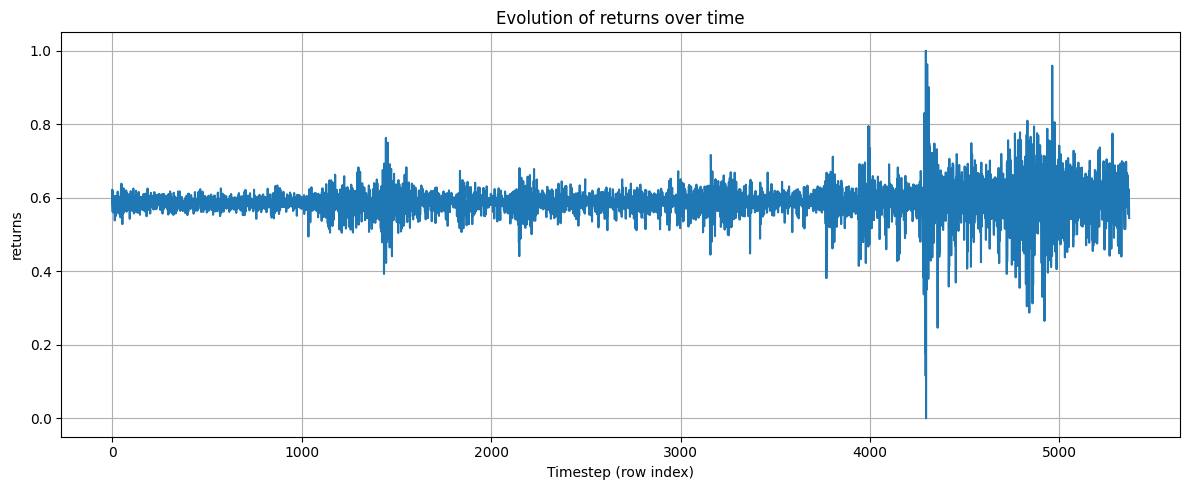

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['returns'])
plt.title('Evolution of returns over time')
plt.xlabel('Timestep (row index)')
plt.ylabel('returns')
plt.grid(True)
plt.tight_layout()
plt.show()


### Base LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1) Load & sort
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

X_raw = df[['volatility', 'Close', 'Volume', 'returns', 'EWMA_VM', 'yang_zhang']].values    # (T, 1)
y_raw = df[['BS_30d_ATM_Call']].values  # (T, 1)

# 2) Scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 3) Build sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t-seq_len:t])
        ys.append(y[t])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# 5) DataLoaders
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train).float(),
                  torch.from_numpy(y_train).float()),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test).float(),
                  torch.from_numpy(y_test).float()),
    batch_size=batch_size, shuffle=False
)

# 6) Model
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model     = LSTMForecast(input_dim=6, hidden_dim=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.lstm.dropout = 0.2

# 7) Train
n_epochs = 100
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    print(f"Epoch {epoch}/{n_epochs} — train MSE: {total_loss/len(train_loader.dataset):.6f}")

# 8) Evaluate
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        p = model(Xb)
        preds.append(p.cpu().numpy())
        trues.append(yb.cpu().numpy())

y_pred_scaled = np.vstack(preds)
y_test_scaled = np.vstack(trues)

# Inverse-scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
r2   = max(0.0, r2)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


Epoch 1/100 — train MSE: 0.219729
Epoch 2/100 — train MSE: 0.153663
Epoch 3/100 — train MSE: 0.145209
Epoch 4/100 — train MSE: 0.143982
Epoch 5/100 — train MSE: 0.141125
Epoch 6/100 — train MSE: 0.140804
Epoch 7/100 — train MSE: 0.139730
Epoch 8/100 — train MSE: 0.138673
Epoch 9/100 — train MSE: 0.137811
Epoch 10/100 — train MSE: 0.137010
Epoch 11/100 — train MSE: 0.137135
Epoch 12/100 — train MSE: 0.137664
Epoch 13/100 — train MSE: 0.137177
Epoch 14/100 — train MSE: 0.136075
Epoch 15/100 — train MSE: 0.134811
Epoch 16/100 — train MSE: 0.135012
Epoch 17/100 — train MSE: 0.133878
Epoch 18/100 — train MSE: 0.134184
Epoch 19/100 — train MSE: 0.134095
Epoch 20/100 — train MSE: 0.134193
Epoch 21/100 — train MSE: 0.132890
Epoch 22/100 — train MSE: 0.133559
Epoch 23/100 — train MSE: 0.132520
Epoch 24/100 — train MSE: 0.132695
Epoch 25/100 — train MSE: 0.131442
Epoch 26/100 — train MSE: 0.131505
Epoch 27/100 — train MSE: 0.129339
Epoch 28/100 — train MSE: 0.129452
Epoch 29/100 — train MSE: 0.1

### EMD LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1) Load & sort
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)


# 1b) DROP any row that has NaNs in the fields we’re about to use:
required_cols = [
    'vol_LSTM', 'Close', 'Volume',
    'returns', 'EWMA_VM', 'yang_zhang',
    'BS_30d_ATM_Call'
]
df = df.dropna(subset=required_cols).reset_index(drop=True)


X_raw = df[['vol_LSTM', 'Close', 'Volume', 'returns', 'EWMA_VM', 'yang_zhang']].values    # (T, 1)
y_raw = df[['BS_30d_ATM_Call']].values  # (T, 1)


# 2) Scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 3) Build sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t-seq_len:t])
        ys.append(y[t])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# 5) DataLoaders
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train).float(),
                  torch.from_numpy(y_train).float()),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test).float(),
                  torch.from_numpy(y_test).float()),
    batch_size=batch_size, shuffle=False
)

# 6) Model
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model     = LSTMForecast(input_dim=6, hidden_dim=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.lstm.dropout = 0.2

# 7) Train
n_epochs = 100
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    print(f"Epoch {epoch}/{n_epochs} — train MSE: {total_loss/len(train_loader.dataset):.6f}")

# 8) Evaluate
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        p = model(Xb)
        preds.append(p.cpu().numpy())
        trues.append(yb.cpu().numpy())

y_pred_scaled = np.vstack(preds)
y_test_scaled = np.vstack(trues)

# Inverse-scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
r2   = max(0.0, r2)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


Epoch 1/100 — train MSE: 0.886215
Epoch 2/100 — train MSE: 0.698933
Epoch 3/100 — train MSE: 0.628466
Epoch 4/100 — train MSE: 0.607091
Epoch 5/100 — train MSE: 0.596037
Epoch 6/100 — train MSE: 0.596427
Epoch 7/100 — train MSE: 0.590699
Epoch 8/100 — train MSE: 0.585167
Epoch 9/100 — train MSE: 0.576039
Epoch 10/100 — train MSE: 0.583765
Epoch 11/100 — train MSE: 0.582692
Epoch 12/100 — train MSE: 0.568817
Epoch 13/100 — train MSE: 0.566214
Epoch 14/100 — train MSE: 0.573528
Epoch 15/100 — train MSE: 0.564594
Epoch 16/100 — train MSE: 0.555176
Epoch 17/100 — train MSE: 0.554330
Epoch 18/100 — train MSE: 0.552253
Epoch 19/100 — train MSE: 0.550335
Epoch 20/100 — train MSE: 0.547041
Epoch 21/100 — train MSE: 0.545451
Epoch 22/100 — train MSE: 0.559984
Epoch 23/100 — train MSE: 0.536240
Epoch 24/100 — train MSE: 0.538732
Epoch 25/100 — train MSE: 0.545317
Epoch 26/100 — train MSE: 0.529686
Epoch 27/100 — train MSE: 0.532353
Epoch 28/100 — train MSE: 0.526587
Epoch 29/100 — train MSE: 0.5

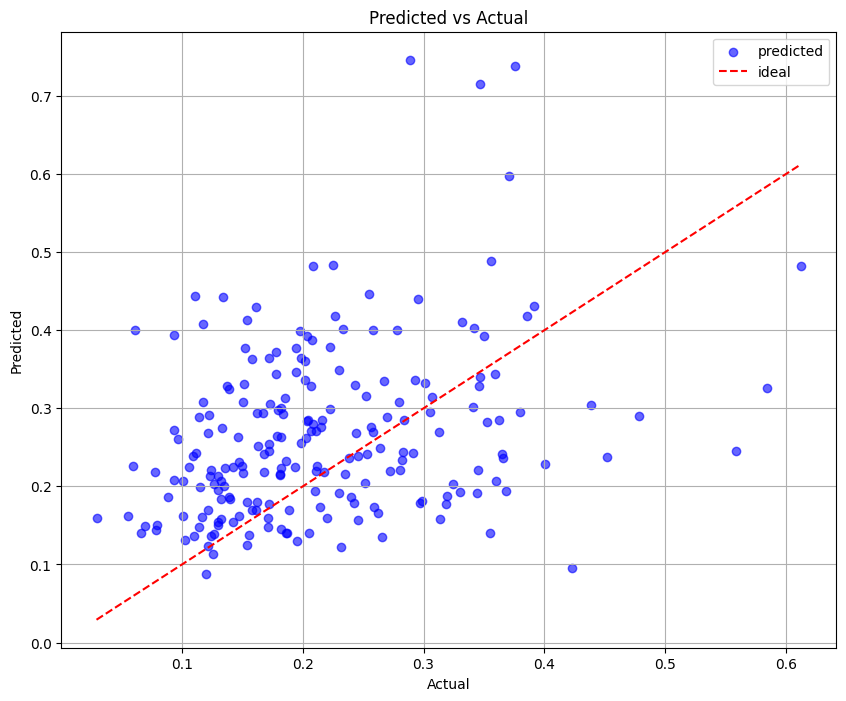

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label="predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="ideal")
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()


## Hyper-parameters tunning

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ---------------------------
# 1) Load & sort
# ---------------------------
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

# ---------------------------
# 2) Encode Date as a numeric feature
# ---------------------------
df['Date_ordinal'] = df['Date'].apply(lambda dt: dt.toordinal())

# ---------------------------
# 3) Define features & target
# ---------------------------
feature_cols = [
    'Date_ordinal',
    'Inflation',
    'CPI',
    'Treasury_Yield',
    #'Open',
    #'High',
    #'Low',
    'Close',
    'SP500_Adj_Close',
    'Volume',
    'GDP',
    'mortage',
    'unemployement',
    'fed_fund_rate',
    'volatility',
    'returns',
    'EWMA_VM',
    'GARCH_VM',
    'EGARCH_VM',
    'RogersSatchell_VM',
    'garman_klass',
    'parkinson',
    'yang_zhang',
    'BS_30d_ATM_Call',
    'move'
]
target_col = 'volatility_forcast'

X_raw = df[feature_cols].values    # shape: (T, 25)
y_raw = df[[target_col]].values    # shape: (T, 1)

# ---------------------------
# 4) Standard‐scale X and y
# ---------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_raw)   # (T, 25)
y_scaled = scaler_y.fit_transform(y_raw)   # (T, 1)

# ---------------------------
# 5) Create sliding‐window sequences
# ---------------------------
def create_sequences(X: np.ndarray, y: np.ndarray, seq_len: int):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t - seq_len:t, :])  # shape: (seq_len, num_features)
        ys.append(y[t, :])              # shape: (1,)
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)
# → X_seq shape = (num_samples, 20, 25)
# → y_seq shape = (num_samples, 1)

# ---------------------------
# 6) Train/Validation/Test split
# ---------------------------
# First split out 20% for test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_seq, y_seq, test_size=0.20, shuffle=False
)
# Then split remaining 80% into train (90% of 80%) and val (10% of 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.10, shuffle=False
)

# ---------------------------
# 7) Device configuration
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 8) Two‐layer LSTM model with dropout
# ---------------------------
class LSTMForecast(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout=0.0):
        super().__init__()
        # First LSTM: input_dim → hidden_dim1
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        # Second LSTM: hidden_dim1 → hidden_dim2
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True)
        self.drop2 = nn.Dropout(dropout)
        # Final Linear: hidden_dim2 → 1
        self.fc    = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        # x has shape (batch_size, seq_len, input_dim)
        out1, _ = self.lstm1(x)      #  → (batch_size, seq_len, hidden_dim1)
        out1 = self.drop1(out1)
        out2, _ = self.lstm2(out1)   #  → (batch_size, seq_len, hidden_dim2)
        out2 = self.drop2(out2)
        last = out2[:, -1, :]        #  take last timestep: (batch_size, hidden_dim2)
        return self.fc(last)         #  → (batch_size, 1)

# ---------------------------
# 9) Hyperparameter grid to search
# ---------------------------
param_grid = {
    'hidden_dim1': [128, 64],
    'hidden_dim2': [64, 32],
    'lr': [1e-3, 1e-4],
    'weight_decay': [1e-5, 1e-6],
    'dropout': [0.1, 0.2]
}

# ---------------------------
# 10) Train & evaluate function (uses ReduceLROnPlateau, early stopping, gradient clipping)
# ---------------------------
def train_and_evaluate(params):
    """
    Trains on (X_train, y_train) with a small validation split (X_val, y_val),
    using hyperparameters in `params`. Returns best validation loss and model state.
    """
    hd1 = params['hidden_dim1']
    hd2 = params['hidden_dim2']
    lr  = params['lr']
    wd  = params['weight_decay']
    do  = params['dropout']

    # Build model + send to device
    model = LSTMForecast(
        input_dim=len(feature_cols),
        hidden_dim1=hd1,
        hidden_dim2=hd2,
        dropout=do
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=wd
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=False
    )

    # Create DataLoaders for train/val
    train_dataset = TensorDataset(
        torch.from_numpy(X_train).float(),
        torch.from_numpy(y_train).float()
    )
    val_dataset = TensorDataset(
        torch.from_numpy(X_val).float(),
        torch.from_numpy(y_val).float()
    )
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

    n_epochs = 50            # for tuning, we use fewer epochs
    patience = 10            # early stopping patience
    best_val_loss = np.inf
    best_state = None
    epochs_no_improve = 0

    for epoch in range(1, n_epochs + 1):
        # ---- Training phase ----
        model.train()
        train_loss_accum = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss.backward()
            # Gradient clipping (max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss_accum += loss.item() * Xb.size(0)

        avg_train_loss = train_loss_accum / len(train_loader.dataset)

        # ---- Validation phase ----
        model.eval()
        val_loss_accum = 0.0
        with torch.no_grad():
            for Xv, yv in val_loader:
                Xv, yv = Xv.to(device), yv.to(device)
                pred_v = model(Xv)
                loss_v = criterion(pred_v, yv)
                val_loss_accum += loss_v.item() * Xv.size(0)

        avg_val_loss = val_loss_accum / len(val_loader.dataset)

        # Step the scheduler on validation loss
        scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss - 1e-6:
            best_val_loss = avg_val_loss
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    return best_val_loss, best_state

# ---------------------------
# 11) Grid search over hyperparameters
# ---------------------------
best_overall = {
    'val_loss': np.inf,
    'params': None,
    'state_dict': None
}

for params in ParameterGrid(param_grid):
    val_loss, state_dict = train_and_evaluate(params)
    if val_loss < best_overall['val_loss']:
        best_overall['val_loss'] = val_loss
        best_overall['params']   = params
        best_overall['state_dict'] = state_dict

print("Best hyperparameters found:")
print(best_overall['params'])
print(f"Validation loss: {best_overall['val_loss']:.6f}")

# ---------------------------
# 12) Final evaluation on the test set
# ---------------------------
# Re‐instantiate the model with the best hyperparameters
hp = best_overall['params']
model_best = LSTMForecast(
    input_dim=len(feature_cols),
    hidden_dim1=hp['hidden_dim1'],
    hidden_dim2=hp['hidden_dim2'],
    dropout=hp['dropout']
).to(device)
model_best.load_state_dict(best_overall['state_dict'])

# Create test DataLoader
test_dataset = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float()
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model_best.eval()
preds_scaled, trues_scaled = [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        p = model_best(Xb)
        preds_scaled.append(p.cpu().numpy())
        trues_scaled.append(yb.cpu().numpy())

y_pred_scaled = np.vstack(preds_scaled)   # (num_test_samples, 1)
y_test_scaled = np.vstack(trues_scaled)   # (num_test_samples, 1)

# Inverse‐scale back to original volatility units
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Compute final metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
r2   = max(0.0, r2)

print(f"\nTest MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


c:\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Best hyperparameters found:
{'dropout': 0.1, 'hidden_dim1': 128, 'hidden_dim2': 64, 'lr': 0.001, 'weight_decay': 1e-05}
Validation loss: 0.335576

Test MSE : 0.005003
Test RMSE: 0.070732
Test MAE : 0.052295
Test R²  : 0.0108
